### 1. Generate CTM

In [33]:
import numpy as np
import pandas as pd

def generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs):
    n_ratings = 10
    n_columns = 12  # Including withdraw and default columns
    matrix = np.zeros((n_ratings, n_columns))
    
    stddev = withdraw_prob / 10
    
    # Specified default rates
    default_rates = np.array([0.00005, 0.0001, 0.0004, 0.0009, 0.0025, 
                              0.007, 0.0128, 0.0601, 0.1575, 0.3537])

    for i in range(n_ratings):
        # Assign specified default probability
        default_prob = default_rates[i]
        
        # Assign withdraw probability following a normal distribution centered around withdraw_prob
        withdraw_prob_sample = np.random.normal(withdraw_prob, stddev)
        
        # Ensure withdraw probability is within the valid range [0, 1]
        withdraw_prob_sample = max(0, min(withdraw_prob_sample, 1))
        
        # Calculate the remaining probability for other transitions
        remaining_prob = 1 - default_prob - withdraw_prob_sample
        
        # Set main diagonal probability
        main_diagonal = np.random.normal(main_diagonal_probs[i], main_diagonal_probs[i]/100)
        
        # Calculate side probabilities based on the number of adjacent ratings
        num_adjacent_ratings = min(i, n_ratings - 1 - i)
        if i == 0:  # Top rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (downwards)
        elif i == 9:  # Bottom rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (upwards)
        elif num_adjacent_ratings == 1:
            side_prob = (remaining_prob - main_diagonal) / 3
        elif num_adjacent_ratings == 2:
            side_prob = (remaining_prob - main_diagonal) / 4
        elif num_adjacent_ratings == 3:
            side_prob = (remaining_prob - main_diagonal) / 5
        else:
            side_prob = (remaining_prob - main_diagonal) / 6
        
        # Set main diagonal
        matrix[i, i] = main_diagonal
        
        # Set probabilities for adjacent ratings with randomness
        for j in range(1, 4):
            if i - j >= 0:  # Lower adjacent ratings, i.e. higher ratings
                matrix[i, i - j] = max(0, side_prob * (4 - j) * np.random.uniform(0.7, 0.9))
            if i + j < n_ratings:  # Upper adjacent ratings, i.e. lower ratings
                matrix[i, i + j] = max(0, side_prob * (4 - j) * np.random.uniform(1.1, 1.3))
        
        # Normalize probabilities for other states while keeping main diagonal fixed
        before_i = np.sum(matrix[i, :i])
        after_i = np.sum(matrix[i, i+1:n_ratings])
        total_adjacent_prob = before_i + after_i
        if total_adjacent_prob > 0:
            matrix[i, :i] *= (remaining_prob - main_diagonal) / total_adjacent_prob
            matrix[i, i+1:n_ratings] *= (remaining_prob - main_diagonal) / total_adjacent_prob
        
        matrix[i, -2] = withdraw_prob_sample  # Withdraw probability
        matrix[i, -1] = default_prob  # Default probability

    # Ensure transition probabilities for Rating 1 and Rating 10 are correctly adjusted
    matrix[0, 1] = max(matrix[0, 1], 1e-5)  # Ensure non-zero probability to transition to Rating 2
    matrix[0, 2] = max(matrix[0, 2], 1e-5)  # Ensure non-zero probability to transition to Rating 3
    matrix[9, 8] = max(matrix[9, 8], 1e-5)  # Ensure non-zero probability to transition to Rating 9
    matrix[9, 7] = max(matrix[9, 7], 1e-5)  # Ensure non-zero probability to transition to Rating 8
    
    # Define row and column labels
    row_labels = [f'Rating {i+1}' for i in range(10)]
    column_labels = [f'Rating {i+1}' for i in range(10)] + ['Withdraw', 'Default']

    # Create a DataFrame with labels
    transition_matrix_df = pd.DataFrame(matrix, index=row_labels, columns=column_labels)

    return transition_matrix_df

# Example usage
withdraw_prob = 0.03  # Centered around value% withdraw probability
# Main diagonal probabilities for each rating
main_diagonal_probs = [0.94, 0.92, 0.90, 0.87, 0.85, 0.82, 0.80, 0.77, 0.73, 0.58]
transition_matrix_df = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)
transition_matrix_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10,Withdraw,Default
Rating 1,0.951813,0.008434,0.005661,0.003053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030989,0.00005
Rating 2,0.010415,0.924883,0.017333,0.011186,0.005705,0.000000,0.000000,0.000000,0.000000,0.000000,0.030377,0.00010
Rating 3,0.011924,0.021391,0.880547,0.030270,0.020259,0.010168,0.000000,0.000000,0.000000,0.000000,0.025041,0.00040
Rating 4,0.006285,0.011498,0.019699,0.873584,0.027455,0.018211,0.009066,0.000000,0.000000,0.000000,0.033302,0.00090
Rating 5,0.000000,0.007415,0.014288,0.022524,0.851221,0.035569,0.023526,0.010920,0.000000,0.000000,0.032037,0.00250
Rating 6,0.000000,0.000000,0.009986,0.019992,0.025490,0.821463,0.041524,0.029459,0.012946,0.000000,0.032140,0.00700
Rating 7,0.000000,0.000000,0.000000,0.009811,0.022769,0.037303,0.793545,0.046763,0.035086,0.016707,0.025215,0.01280
Rating 8,0.000000,0.000000,0.000000,0.000000,0.010224,0.019753,0.034712,0.771848,0.043773,0.031704,0.027887,0.06010
Rating 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.007964,0.015282,0.025549,0.724149,0.037949,0.031608,0.15750
Rating 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006747,0.016040,0.021334,0.572758,0.029422,0.35370


### 2. Simulate Credit Migration process
* calculate the conditional PD for each year
* store the survivor counts of each year and each original rating for future ECL calculation.

In [34]:
import numpy as np
import pandas as pd

def simulate_transitions(n_obligors, transition_matrix, quarters=13):
    n_ratings = transition_matrix.shape[0]  # Number of ratings
    n_columns = transition_matrix.shape[1]  # Number of states including Withdraw and Default
    
    cumulative_withdraws = np.zeros((quarters, n_ratings))
    cumulative_defaults = np.zeros((quarters, n_ratings))
    cumulative_survivors = np.zeros((quarters, n_ratings))

    # Initialize obligors matrix with shape (quarters, n_ratings, n_ratings)
    obligors = np.zeros((quarters, n_ratings, n_columns))
    for i in range(n_ratings):
        original_obligors_count = n_obligors / n_ratings  # Distribute obligors equally at the start
        obligors[0, i, i] = original_obligors_count
        cumulative_survivors[0, i] = original_obligors_count

    for t in range(1, quarters):
        for i in range(n_ratings):  # Only consider ratings, exclude Withdraw and Default columns
            for j in range(n_ratings):  # For each rating's distribution vector
                if obligors[t-1, i, j] > 0:
                    available_obligors = obligors[t-1, i, j]

                    transitions = available_obligors * transition_matrix.iloc[j].values
                    transitions = np.round(transitions).astype(int)

                    # Update obligors for next state
                    obligors[t, i, :] += transitions[:n_columns]

                    # Accumulate withdraws and defaults for each rating
                    if cumulative_withdraws[t, i] == 0 and cumulative_defaults[t, i] == 0:
                        cumulative_withdraws[t, i] = cumulative_withdraws[t - 1, i]
                        cumulative_defaults[t, i] = cumulative_defaults[t - 1, i]
                    cumulative_withdraws[t, i] += transitions[-2]
                    cumulative_defaults[t, i] += transitions[-1]
                    
                    # Calculate the survivors for each period
                    if cumulative_survivors[t, i] == 0:
                        cumulative_survivors[t, i] = cumulative_survivors[t-1, i]
                    cumulative_survivors[t, i] -= (transitions[-1] + transitions[-2])

    # Calculate marginal default rate for each year
    marginal_default_rates = np.zeros((quarters, n_ratings))
    for t in range(1, quarters):
        for i in range(n_ratings):
            if cumulative_survivors[t-1, i] > 0:
                marginal_default_rates[t, i] = (cumulative_defaults[t, i] - cumulative_defaults[t - 1, i]) / cumulative_survivors[t-1, i]
            else:
                marginal_default_rates[t, i] = 0

    # Final matrix for the count of each original obligor
    final_matrix = np.zeros((n_ratings, n_columns))
    final_matrix[:, :-2] = obligors[-1, :, :-2]
    final_matrix[:, -2] = cumulative_withdraws[-1, :]
    final_matrix[:, -1] = cumulative_defaults[-1, :]

    return cumulative_withdraws, cumulative_defaults, cumulative_survivors, obligors, marginal_default_rates, final_matrix

In [35]:
marginal_default_rates

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e-04, 4.00000000e-04, 9.00000000e-04,
        2.50000000e-03, 7.00000000e-03, 1.28000000e-02, 6.01000000e-02,
        1.57500000e-01, 3.53700000e-01],
       [0.00000000e+00, 1.02986612e-04, 4.13265833e-04, 1.13989637e-03,
        3.51639259e-03, 1.06658383e-02, 2.43876800e-02, 7.14285714e-02,
        1.58194187e-01, 3.35175553e-01],
       [0.00000000e+00, 1.06055785e-04, 5.33731853e-04, 1.50343643e-03,
        5.14028700e-03, 1.40071113e-02, 3.20885510e-02, 7.73868110e-02,
        1.56436553e-01, 3.11698307e-01],
       [0.00000000e+00, 1.09241861e-04, 7.71860183e-04, 2.11416490e-03,
        6.55337110e-03, 1.72239108e-02, 3.73786989e-02, 8.04645375e-02,
        1.52145152e-01, 2.83873487e-01],
       [0.00000000e+00, 2.25073149e-04, 1.13921167e-03, 2.76848541e-03,
   

### 3. Survivor Count for each period

In [36]:
# Simulate the transitions for 100,000 obligors over 10 periods
n_obligors = 100000
quarters = 11  # Simulate for 10 periods
cumulative_withdraws_corrected, cumulative_defaults_corrected, cumulative_survivors_corrected, obligors_corrected, marginal_default_rates, final_matrix = simulate_transitions(n_obligors, transition_matrix_df, quarters)

# Create DataFrames to store and display the results
survivors_df = pd.DataFrame(cumulative_survivors_corrected, columns=[f'Rating_{i+1}' for i in range(cumulative_survivors_corrected.shape[1])])
marginal_defaults_df = pd.DataFrame(marginal_default_rates, columns=[f'Rating_{i+1}' for i in range(marginal_default_rates.shape[1])])
defaults_df = pd.DataFrame(cumulative_defaults_corrected, columns=[f'Rating_{i+1}' for i in range(cumulative_defaults_corrected.shape[1])])

# Display the survivor counts
print("Survivor Counts Over 10 Periods:")
survivors_df

Survivor Counts Over 10 Periods:


,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5,Rating_6,Rating_7,Rating_8,Rating_9,Rating_10
0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
1,9690.0,9695.0,9746.0,9658.0,9655.0,9609.0,9620.0,9120.0,8109.0,6169.0
2,9390.0,9400.0,9489.0,9329.0,9316.0,9203.0,9121.0,8214.0,6563.0,3916.0
3,9099.0,9115.0,9234.0,9010.0,8979.0,8786.0,8565.0,7347.0,5324.0,2577.0
4,8818.0,8837.0,8979.0,8699.0,8640.0,8361.0,7992.0,6547.0,4341.0,1765.0
5,8545.0,8570.0,8725.0,8396.0,8301.0,7935.0,7427.0,5831.0,3568.0,1263.0
6,8282.0,8310.0,8473.0,8098.0,7964.0,7511.0,6883.0,5195.0,2960.0,946.0
7,8027.0,8056.0,8220.0,7806.0,7630.0,7096.0,6367.0,4637.0,2479.0,736.0
8,7780.0,7809.0,7969.0,7520.0,7301.0,6696.0,5886.0,4149.0,2097.0,596.0
9,7541.0,7568.0,7719.0,7242.0,6978.0,6310.0,5441.0,3723.0,1794.0,497.0


In [37]:
defaults_df

,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5,Rating_6,Rating_7,Rating_8,Rating_9,Rating_10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,4.0,9.0,25.0,70.0,128.0,601.0,1575.0,3537.0
2,0.0,2.0,10.0,20.0,58.0,172.0,376.0,1251.0,2867.0,5608.0
3,0.0,3.0,15.0,35.0,102.0,302.0,686.0,1886.0,3903.0,6832.0
4,0.0,4.0,23.0,54.0,160.0,455.0,1024.0,2476.0,4722.0,7568.0
5,0.0,5.0,33.0,78.0,230.0,625.0,1368.0,3005.0,5364.0,8019.0
6,0.0,7.0,46.0,109.0,311.0,807.0,1704.0,3472.0,5865.0,8300.0
7,0.0,10.0,62.0,143.0,400.0,992.0,2024.0,3880.0,6257.0,8482.0
8,0.0,14.0,82.0,183.0,495.0,1178.0,2324.0,4233.0,6565.0,8602.0
9,0.0,20.0,105.0,226.0,595.0,1361.0,2601.0,4538.0,6808.0,8685.0


In [38]:
# Parameters
LGD = 1
EAD = 1

# Calculate real credit loss at 5 years (time unit 5) and 10 years (time unit 10)
credit_loss_5_year = defaults_df.iloc[5] * LGD * EAD
credit_loss_10_year = defaults_df.iloc[10] * LGD * EAD

# Display the results
credit_loss_5_year_df = pd.DataFrame(credit_loss_5_year).transpose()
credit_loss_10_year_df = pd.DataFrame(credit_loss_10_year).transpose()

print("Credit Loss at 5 Years:")
credit_loss_5_year_df

Credit Loss at 5 Years:


,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5,Rating_6,Rating_7,Rating_8,Rating_9,Rating_10
5,0.0,5.0,33.0,78.0,230.0,625.0,1368.0,3005.0,5364.0,8019.0


In [39]:
print("\nCredit Loss at 10 Years:")
credit_loss_10_year_df


Credit Loss at 10 Years:


,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5,Rating_6,Rating_7,Rating_8,Rating_9,Rating_10
10,0.0,28.0,129.0,273.0,697.0,1538.0,2854.0,4800.0,7000.0,8744.0


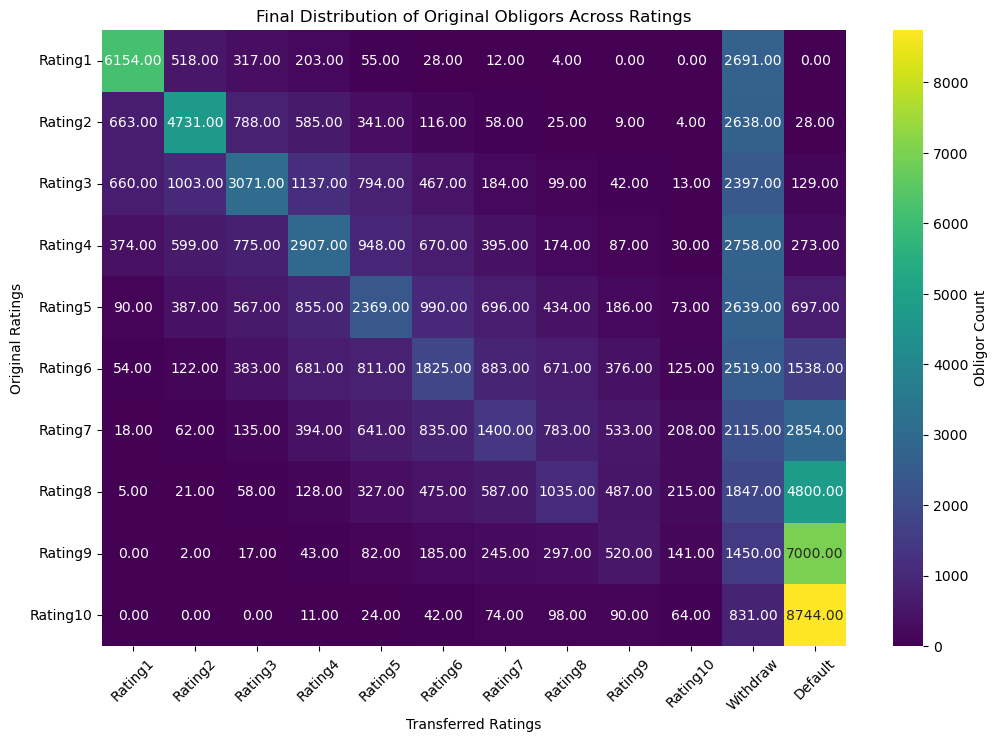

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Manually define the row and column labels
row_labels = [f'Rating{i+1}' for i in range(10)]  # Original ratings
column_labels = [f'Rating{i+1}' for i in range(10)] + ['Withdraw', 'Default']  # Transferred ratings

# Convert `final_matrix` to a DataFrame for better visualization
final_matrix_df = pd.DataFrame(final_matrix, index=row_labels, columns=column_labels)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(final_matrix_df, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Obligor Count'})
plt.title('Final Distribution of Original Obligors Across Ratings')
plt.xlabel('Transferred Ratings')
plt.ylabel('Original Ratings')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

### 4. Conditional PD for each period

In [41]:
# Display the marginal default rates
print("\nMarginal Default Rates Over 10 Periods:")
marginal_defaults_df


Marginal Default Rates Over 10 Periods:


,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5,Rating_6,Rating_7,Rating_8,Rating_9,Rating_10
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000100,0.000400,0.000900,0.002500,0.007000,0.012800,0.060100,0.157500,0.353700
2,0.0,0.000103,0.000616,0.001139,0.003418,0.010615,0.025780,0.071272,0.159329,0.335711
3,0.0,0.000106,0.000527,0.001608,0.004723,0.014126,0.033988,0.077307,0.157855,0.312564
4,0.0,0.000110,0.000866,0.002109,0.006460,0.017414,0.039463,0.080305,0.153832,0.285603
5,0.0,0.000113,0.001114,0.002759,0.008102,0.020332,0.043043,0.080800,0.147892,0.255524
6,0.0,0.000233,0.001490,0.003692,0.009758,0.022936,0.045240,0.080089,0.140415,0.222486
7,0.0,0.000361,0.001888,0.004199,0.011175,0.024631,0.046491,0.078537,0.132432,0.192389
8,0.0,0.000497,0.002433,0.005124,0.012451,0.026212,0.047118,0.076127,0.124244,0.163043
9,0.0,0.000768,0.002886,0.005718,0.013697,0.027330,0.047061,0.073512,0.115880,0.139262


### 5. Plot of Survivor Count and Conditional PD

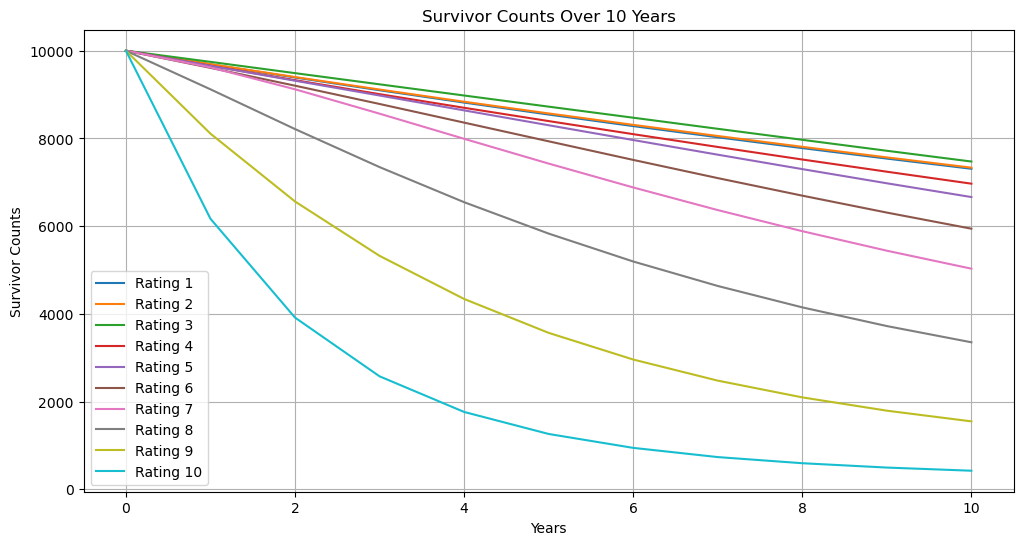

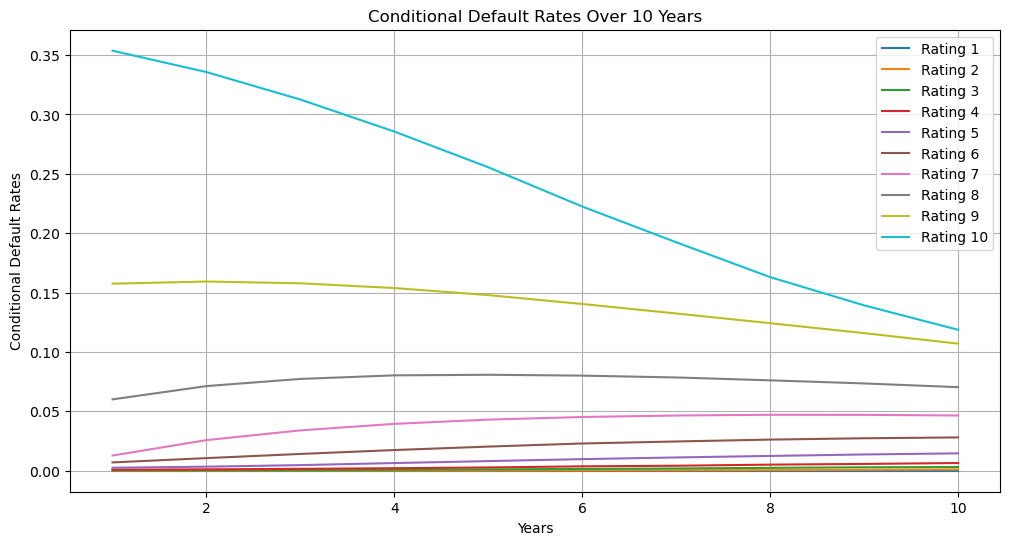

In [42]:
import matplotlib.pyplot as plt

# Plot survivor counts
plt.figure(figsize=(12, 6))
for i in range(survivors_df.shape[1]):
    plt.plot(survivors_df.index, survivors_df[f'Rating_{i+1}'], label=f'Rating {i+1}')
plt.xlabel('Years')
plt.ylabel('Survivor Counts')
plt.title('Survivor Counts Over 10 Years')
plt.legend()
plt.grid(True)
plt.show()

# Removing time zero default rates
marginal_defaults_df = marginal_defaults_df.iloc[1:]

# Plot marginal default rates
plt.figure(figsize=(12, 6))
for i in range(marginal_defaults_df.shape[1]):
    plt.plot(marginal_defaults_df.index, marginal_defaults_df[f'Rating_{i+1}'], label=f'Rating {i+1}')
plt.xlabel('Years')
plt.ylabel('Conditional Default Rates')
plt.title('Conditional Default Rates Over 10 Years')
plt.legend()
plt.grid(True)
plt.show()

### 6. Survivor Count for rating 9 and 10 over 10 periods

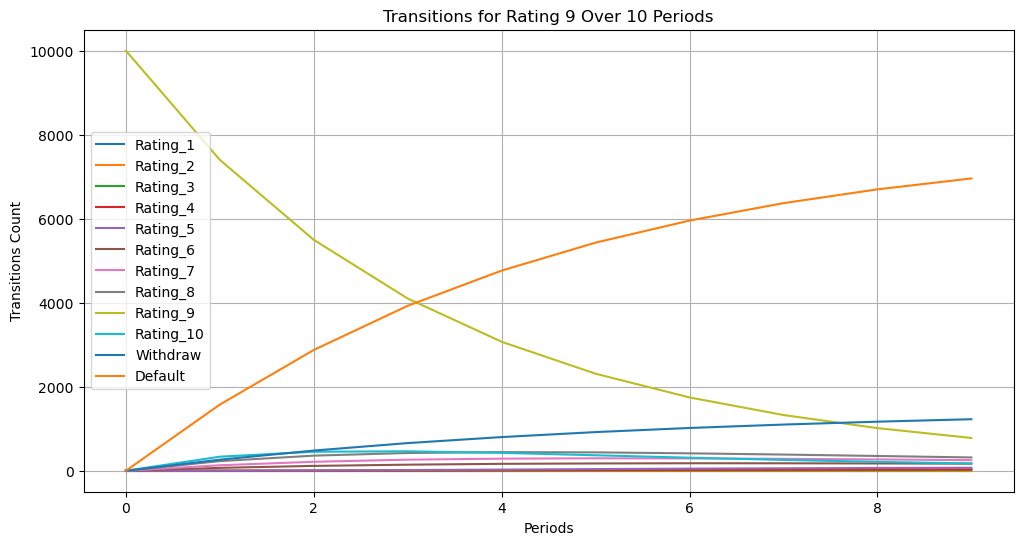

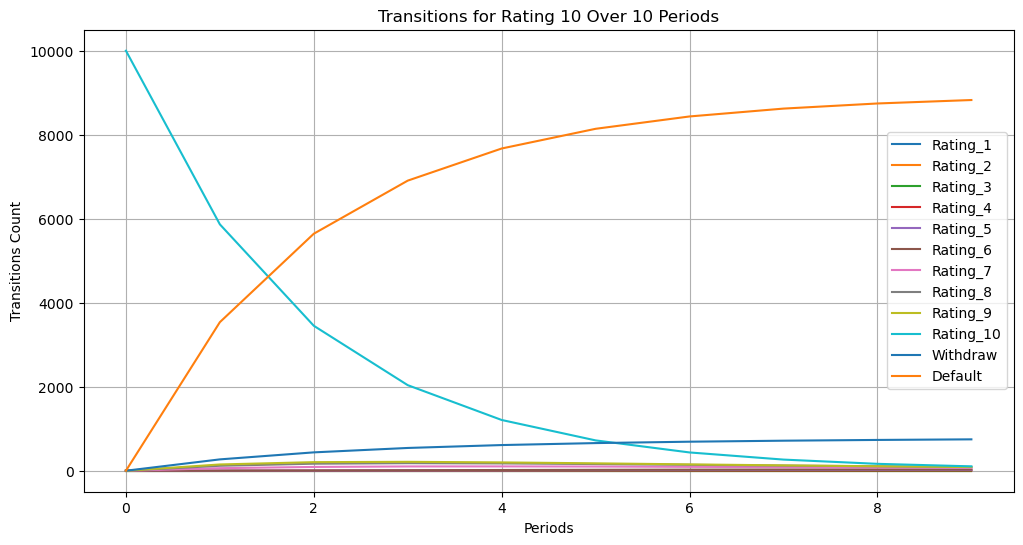

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_transitions_nine_ten(n_obligors, transition_matrix, quarters=13):
    n_ratings = transition_matrix.shape[0]  # Number of ratings
    n_columns = transition_matrix.shape[1]  # Number of states including Withdraw and Default
    
    transitions_rating_9 = np.zeros((quarters, n_columns))
    transitions_rating_10 = np.zeros((quarters, n_columns))
    
    transitions_rating_9[0, 8] = 10000
    transitions_rating_10[0, 9] = 10000

    # Initialize obligors matrix with shape (quarters, n_ratings, n_ratings)
    obligors = np.zeros((quarters, n_ratings, n_ratings))
    for i in range(n_ratings):
        original_obligors_count = n_obligors / n_ratings  # Distribute obligors equally at the start
        obligors[0, i, i] = original_obligors_count

    for t in range(1, quarters):
        for i in range(n_ratings):  # Only consider ratings, exclude Withdraw and Default columns
            for j in range(n_ratings):  # For each rating's distribution vector
                if obligors[t-1, i, j] > 0:
                    available_obligors = obligors[t-1, i, j]

                    transitions = available_obligors * transition_matrix.iloc[j].values
                    transitions = np.round(transitions).astype(int)

                    # Update obligors for next state
                    obligors[t, i, :] += transitions[:n_ratings]

                    # Track transitions specifically for rating 9 and rating 10
                    if i == 8:  # Rating 9 (index 8)
                        if transitions_rating_9[t, -1] == 0 and transitions_rating_9[t, -2] == 0:
                            transitions_rating_9[t, -1] = transitions_rating_9[t - 1, -1]
                            transitions_rating_9[t, -2] = transitions_rating_9[t - 1, -2]
                        transitions_rating_9[t, :] += transitions
                    if i == 9:  # Rating 10 (index 9)
                        if transitions_rating_10[t, -1] == 0 and transitions_rating_10[t, -2] == 0:
                            transitions_rating_10[t, -1] = transitions_rating_10[t - 1, -1]
                            transitions_rating_10[t, -2] = transitions_rating_10[t - 1, -2]
                        transitions_rating_10[t, :] += transitions

    return transitions_rating_9, transitions_rating_10

# Simulate the transitions for 100,000 obligors over 10 periods
n_obligors = 100000
quarters = 10  # Simulate for 10 periods
transitions_rating_9, transitions_rating_10 = simulate_transitions_nine_ten(n_obligors, transition_matrix_df, quarters)

# Create DataFrames to store and display the results
transitions_rating_9_df = pd.DataFrame(transitions_rating_9, columns=[f'Rating_{i+1}' for i in range(10)] + ['Withdraw', 'Default'])
transitions_rating_10_df = pd.DataFrame(transitions_rating_10, columns=[f'Rating_{i+1}' for i in range(10)] + ['Withdraw', 'Default'])

# Plot transitions for rating 9
plt.figure(figsize=(12, 6))
for column in transitions_rating_9_df.columns:
    plt.plot(transitions_rating_9_df.index, transitions_rating_9_df[column], label=column)
plt.xlabel('Periods')
plt.ylabel('Transitions Count')
plt.title('Transitions for Rating 9 Over 10 Periods')
plt.legend()
plt.grid(True)
plt.show()

# Plot transitions for rating 10
plt.figure(figsize=(12, 6))
for column in transitions_rating_10_df.columns:
    plt.plot(transitions_rating_10_df.index, transitions_rating_10_df[column], label=column)
plt.xlabel('Periods')
plt.ylabel('Transitions Count')
plt.title('Transitions for Rating 10 Over 10 Periods')
plt.legend()
plt.grid(True)
plt.show()

Both Rating 9 and Rating 10 show a significant number of defaults and withdrawals in the early periods. This indicates that the most vulnerable accounts in these categories tend to default or withdraw early on.

### 7. ECL for ten unit times & ten original ratings

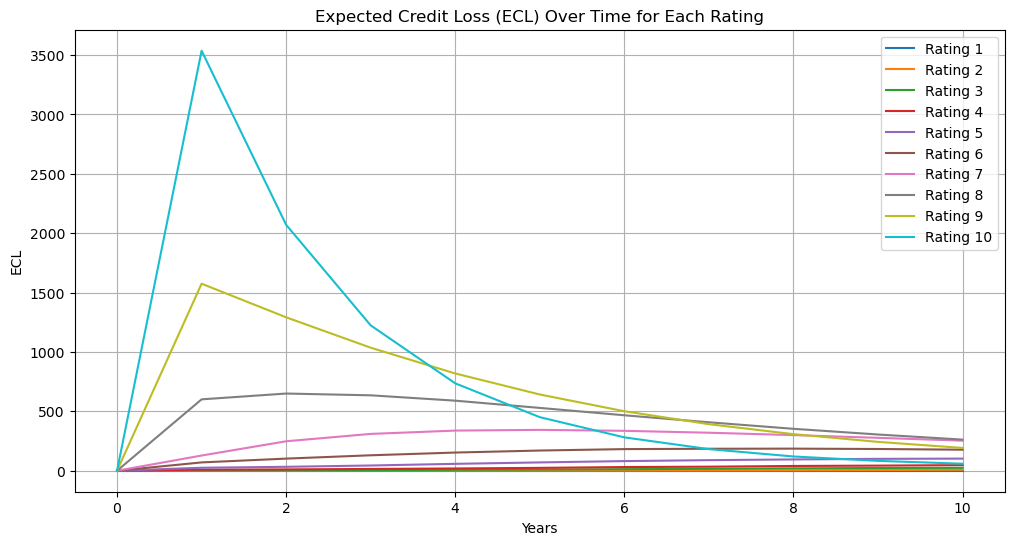

In [43]:
EAD = 1
LGD = 1
discount_rate = 1

def calculate_ecl_per_rating(cumulative_survivors, marginal_default_rates, EAD, LGD, discount_rate):
    n_ratings = cumulative_survivors.shape[1]
    ECL = np.zeros((cumulative_survivors.shape[0], n_ratings))
    for t in range(1, cumulative_survivors.shape[0]):
        ECL[t, :] = cumulative_survivors[t-1, :] * marginal_default_rates[t, :] * LGD * EAD
    return ECL

# Calculate ECL for each rating over 10 years
ecl_per_rating = calculate_ecl_per_rating(cumulative_survivors_corrected, marginal_default_rates, EAD, LGD, discount_rate)

# Plot the ECL over time for each rating
plt.figure(figsize=(12, 6))
for i in range(ecl_per_rating.shape[1]):
    plt.plot(range(11), ecl_per_rating[:, i], label=f'Rating {i+1}')
plt.xlabel('Years')
plt.ylabel('ECL')
plt.title('Expected Credit Loss (ECL) Over Time for Each Rating')
plt.legend()
plt.grid(True)
plt.show()

### 8. Cumulative ECL at time 5 and 10

In [44]:
# Sum the ECL for each rating over 5 years and 10 years
ecl_sum_5_years = ecl_per_rating[:6].sum(axis=0)  # First 5 years (6 rows including the initial row)
ecl_sum_10_years = ecl_per_rating.sum(axis=0)     # Full 10 years

# Create a DataFrame to display the results in the desired format
ecl_summary_df = pd.DataFrame({
    'Rating': [f'Rating {i+1}' for i in range(ecl_per_rating.shape[1])],
    '5-year ECL': ecl_sum_5_years,
    '10-year ECL': ecl_sum_10_years
})

ecl_summary_df

,Rating,5-year ECL,10-year ECL
0,Rating 1,0.0,0.0
1,Rating 2,5.0,28.0
2,Rating 3,33.0,129.0
3,Rating 4,78.0,273.0
4,Rating 5,230.0,697.0
5,Rating 6,625.0,1538.0
6,Rating 7,1368.0,2854.0
7,Rating 8,3005.0,4800.0
8,Rating 9,5364.0,7000.0
9,Rating 10,8019.0,8744.0


### 9. Cumulative ECL using real transition

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_transitions(n_obligors, transition_matrix, quarters=11, lgd=1.0, ead=1.0):
    n_ratings = transition_matrix.shape[0]  # Number of ratings
    n_columns = transition_matrix.shape[1]  # Number of states including Withdraw and Default
    
    cumulative_withdraws = np.zeros((quarters, n_ratings))
    cumulative_defaults = np.zeros((quarters, n_ratings))
    cumulative_survivors = np.zeros((quarters, n_ratings))
    ecl_per_quarter = np.zeros((quarters, n_ratings))  # To store ECL for each quarter and rating

    # Initialize obligors matrix with shape (quarters, n_ratings, n_ratings)
    obligors = np.zeros((quarters, n_ratings, n_ratings))
    for i in range(n_ratings):
        original_obligors_count = n_obligors / n_ratings  # Distribute obligors equally at the start
        obligors[0, i, i] = original_obligors_count
        cumulative_survivors[0, i] = original_obligors_count

    for t in range(1, quarters):
        for i in range(n_ratings):  # Only consider ratings, exclude Withdraw and Default columns
            for j in range(n_ratings):  # For each rating's distribution vector
                if obligors[t-1, i, j] > 0:
                    available_obligors = obligors[t-1, i, j]

                    transitions = available_obligors * transition_matrix.iloc[j].values
                    transitions = np.round(transitions).astype(int)

                    # Ensure transitions do not exceed available obligors
                    while transitions.sum() > available_obligors:
                        transitions[np.argmax(transitions)] -= 1

                    # Update obligors for next state
                    obligors[t, i, :] += transitions[:n_ratings]

                    # Accumulate withdraws and defaults for each rating
                    if cumulative_withdraws[t, i] == 0 and cumulative_defaults[t, i] == 0:
                        cumulative_withdraws[t, i] = cumulative_withdraws[t - 1, i]
                        cumulative_defaults[t, i] = cumulative_defaults[t - 1, i]
                    cumulative_withdraws[t, i] += transitions[-2]
                    cumulative_defaults[t, i] += transitions[-1]
                    
                    # Accumulate survivors for each rating
                    cumulative_survivors[t, i] += np.sum(transitions[:n_ratings])
                    
                    # Calculate ECL for the current quarter and rating
                    default_count = transitions[-1]
                    ecl_per_quarter[t, i] += default_count * lgd * ead

    # Calculate cumulative ECL for each rating
    cumulative_ecl = np.sum(ecl_per_quarter, axis=0)

    return cumulative_withdraws, cumulative_defaults, cumulative_survivors, obligors, ecl_per_quarter, cumulative_ecl

def calculate_ecl_summary(n_obligors, transition_matrix, quarters=11, lgd=1.0, ead=1.0):
    """
    Calculate the Expected Credit Loss (ECL) summary for the given number of obligors and transition matrix.

    Parameters:
    n_obligors (int): Total number of obligors.
    transition_matrix (pd.DataFrame): The transition matrix.
    quarters (int): Number of quarters to simulate. Default is 11.
    lgd (float): Loss given default. Default is 1.0.
    ead (float): Exposure at default per customer. Default is 100.0.

    Returns:
    pd.DataFrame: A DataFrame containing the 5-time ECL and 10-time ECL for each rating.
    """
    cumulative_withdraws, cumulative_defaults, cumulative_survivors, obligors, ecl_per_quarter, cumulative_ecl = simulate_transitions(n_obligors, transition_matrix, quarters, lgd, ead)

    # Calculate 5-time ECL and 10-time ECL
    ecl_5_time = np.sum(ecl_per_quarter[:6], axis=0)
    ecl_10_time = np.sum(ecl_per_quarter[:11], axis=0)

    # Convert ecl_per_quarter to integers
    ecl_per_quarter_int = ecl_per_quarter.astype(int)

    # Convert ecl_per_quarter_int to a DataFrame
    ecl_df = pd.DataFrame(ecl_per_quarter_int, columns=[f'Rating {i+1}' for i in range(10)])
    ecl_df.index.name = 'Quarter'

    # Add the 5-time and 10-time ECL to the DataFrame
    ecl_summary_df = pd.DataFrame({
        'Rating': [f'Rating {i+1}' for i in range(10)],
        '5-Year Real CL': ecl_5_time,
        '10-Year Real CL': ecl_10_time
    })

    return ecl_summary_df

# Example usage with a sample transition matrix and withdraw counts
n_obligors = 100000
quarters = 11

# Assuming transition_matrix_df is defined
ecl_summary_df = calculate_ecl_summary(n_obligors, transition_matrix_df, quarters)

# Print the results
ecl_summary_df

,Rating,5-Year Real CL,10-Year Real CL
0,Rating 1,0.0,0.0
1,Rating 2,5.0,28.0
2,Rating 3,33.0,129.0
3,Rating 4,78.0,272.0
4,Rating 5,228.0,695.0
5,Rating 6,625.0,1537.0
6,Rating 7,1367.0,2851.0
7,Rating 8,3005.0,4799.0
8,Rating 9,5363.0,6996.0
9,Rating 10,8018.0,8742.0


In [20]:
n_obligors = 100000
a = [*range(1,11)]*n_obligors
year = 10

# Convert the DataFrame to a NumPy array
transition_matrix = transition_matrix_df.to_numpy()
tm = transition_matrix

matrix_1, tm_1y, multi_matrix, multi_tm, df_multiyear, wd_multiyear = simu_tm_multiyear(a, tm, year)

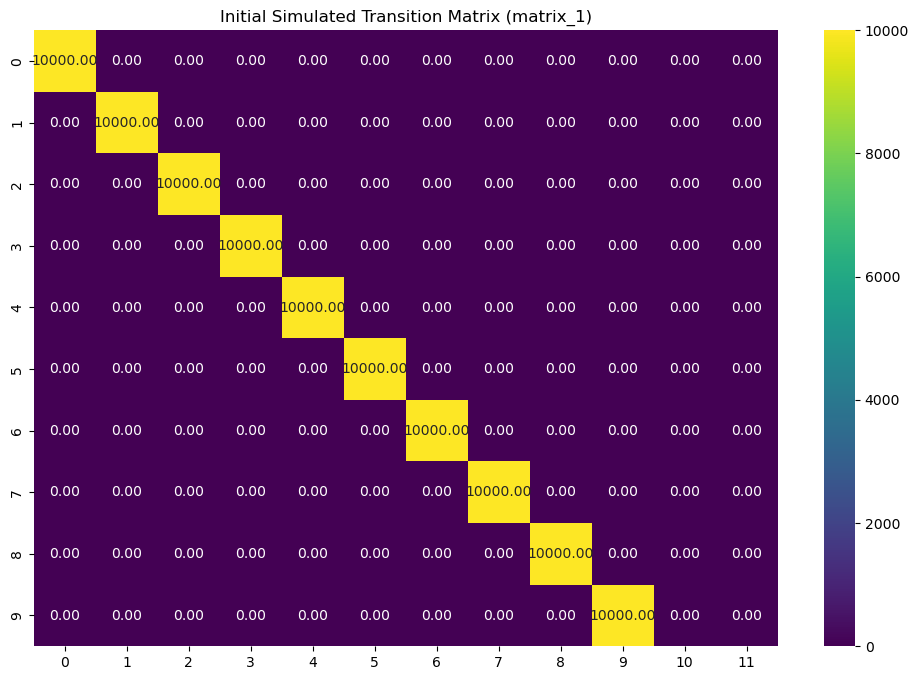

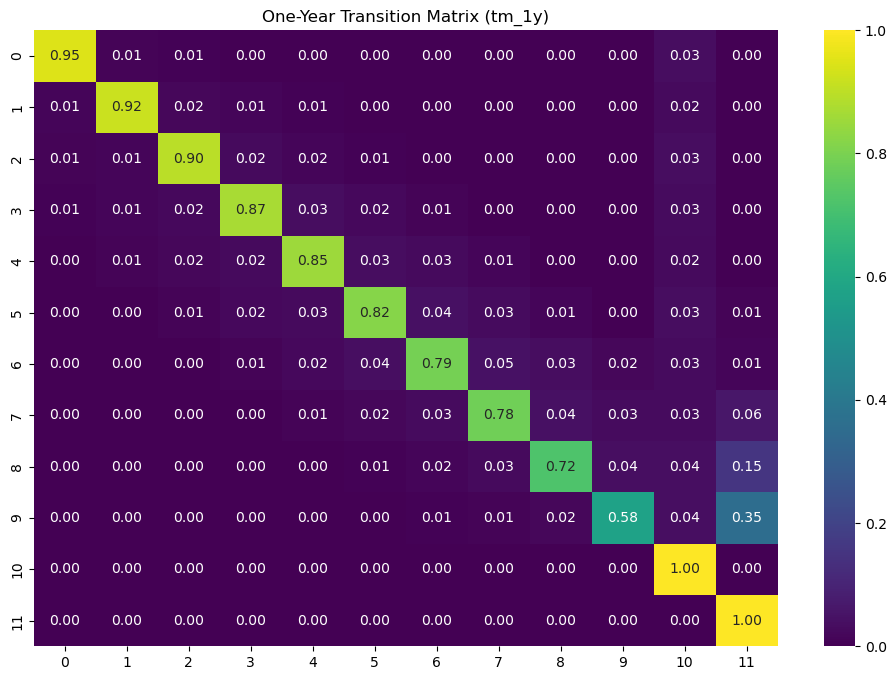

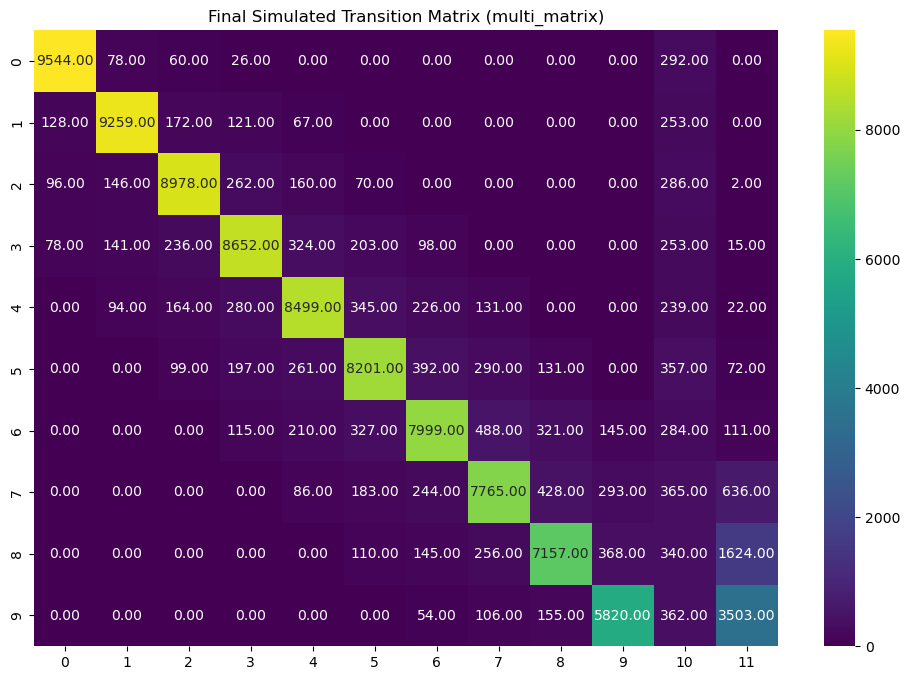

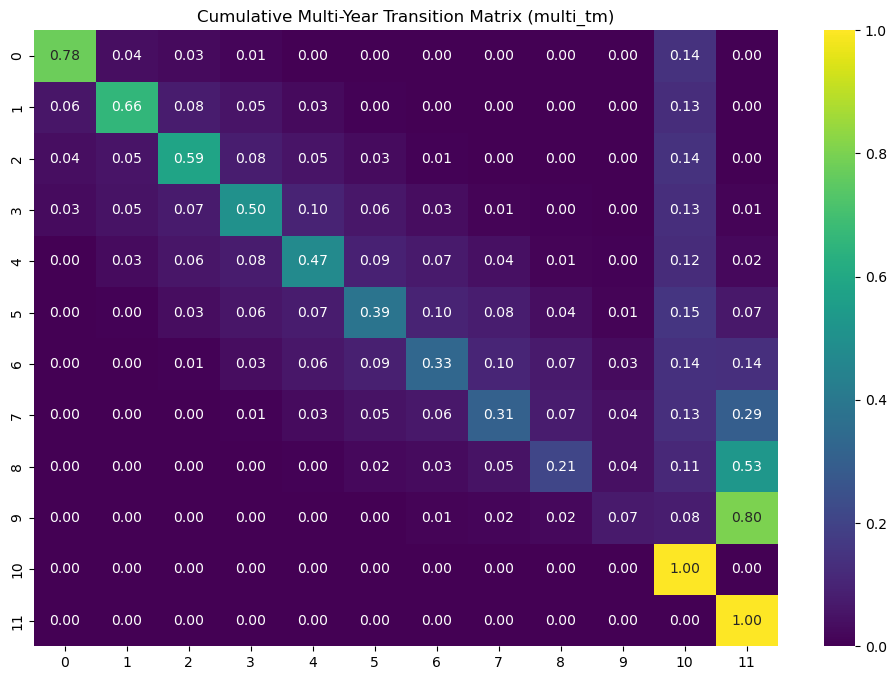

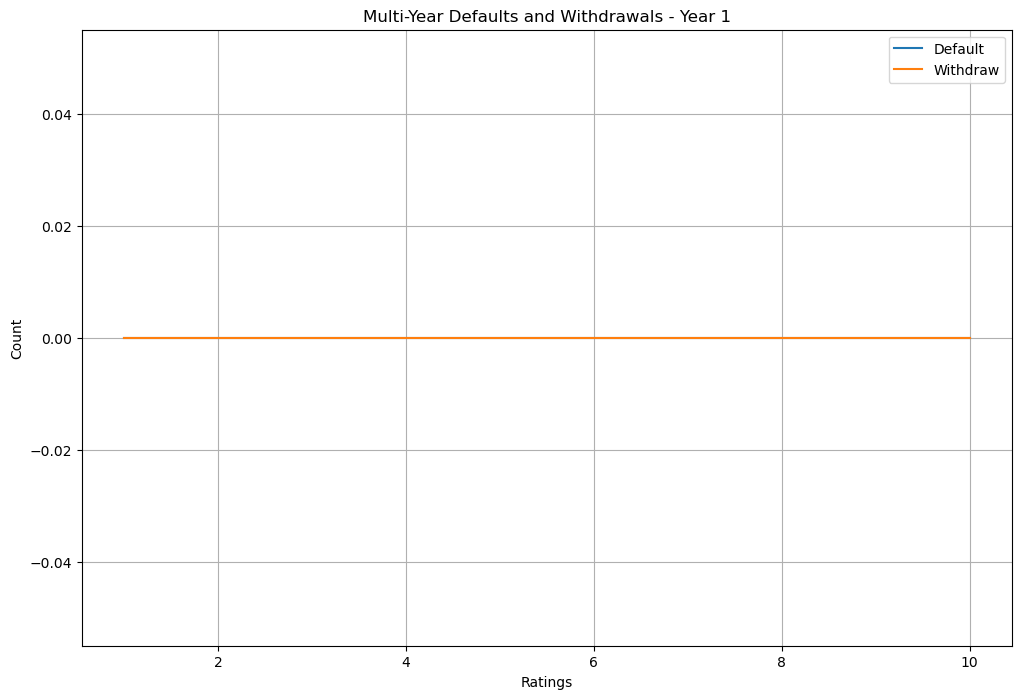

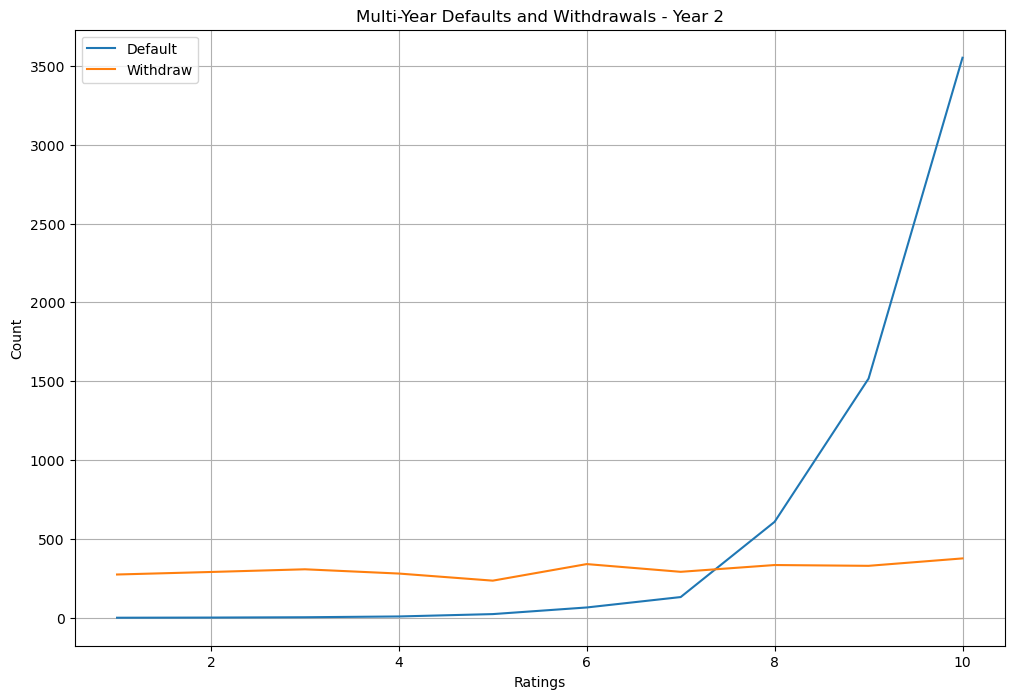

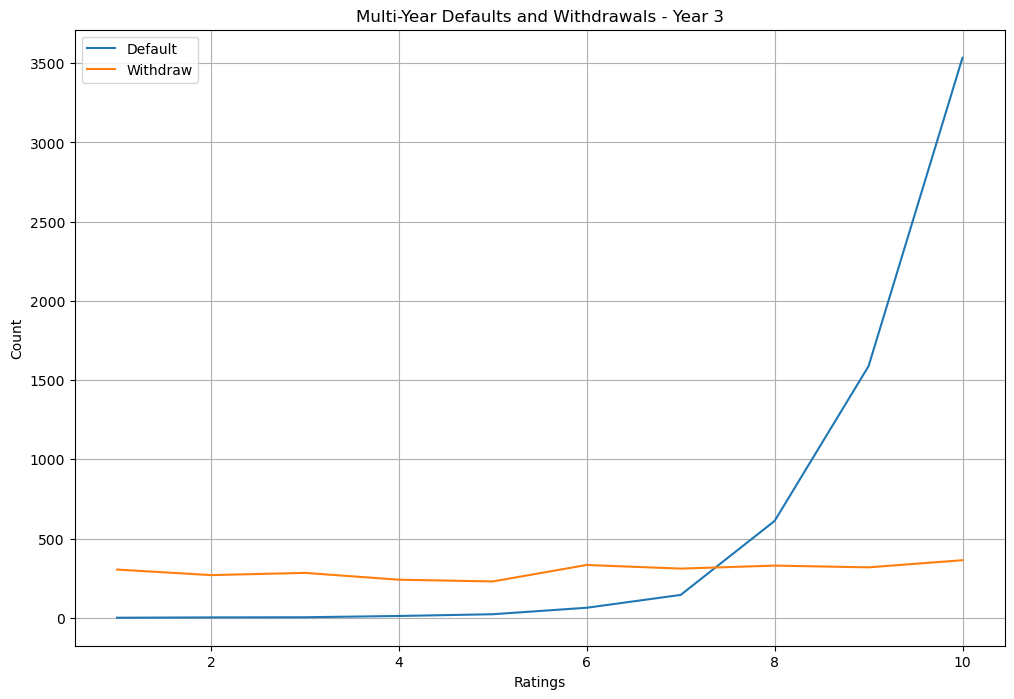

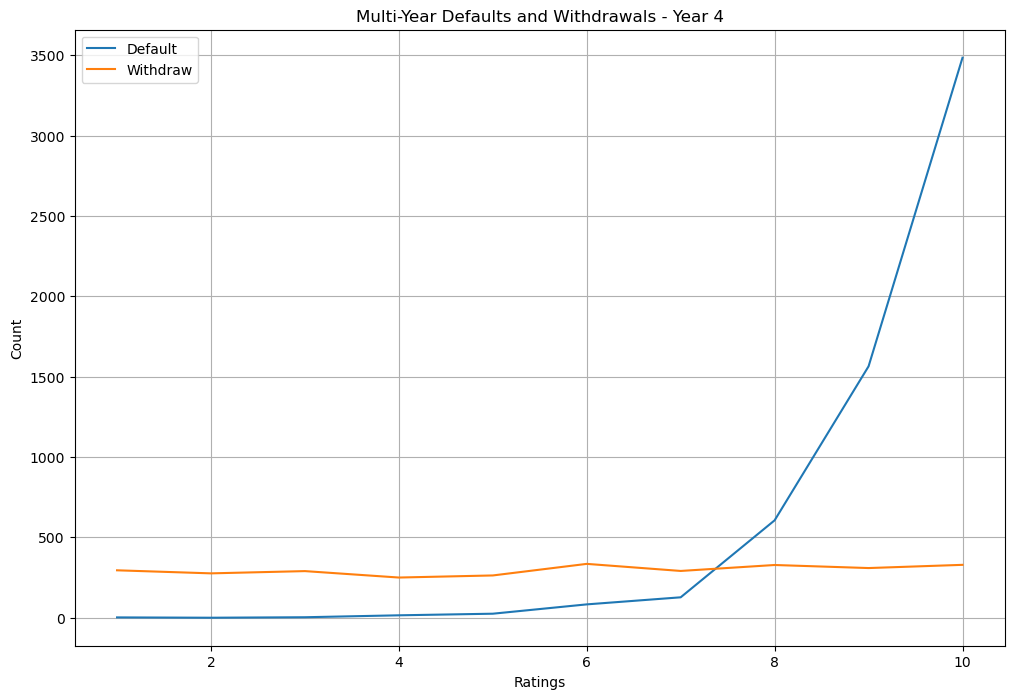

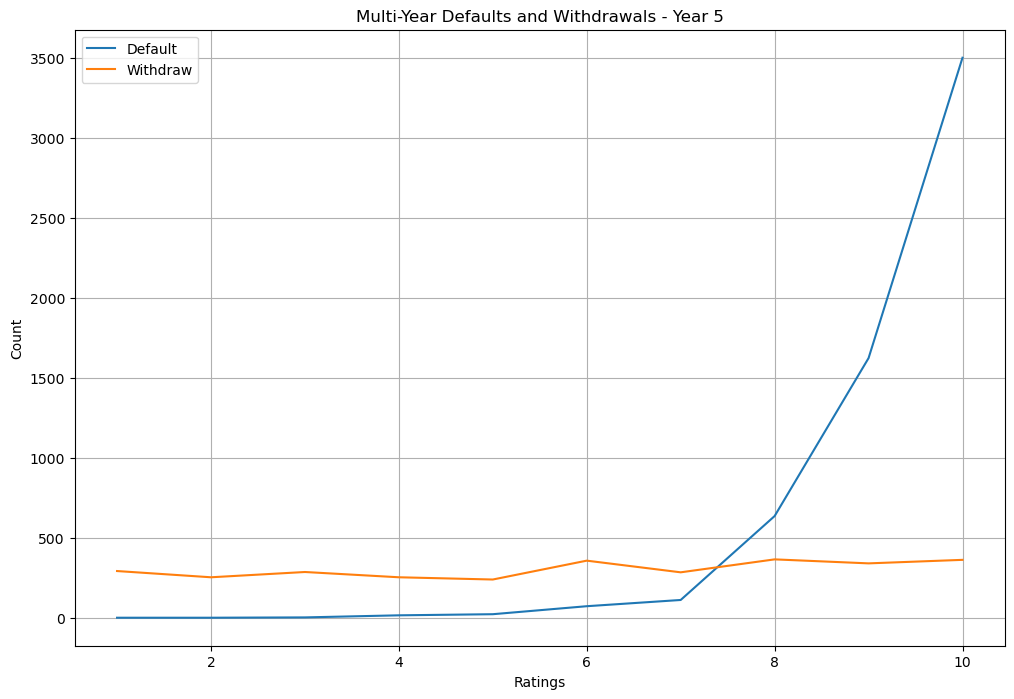

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualization code
def visualize_matrix(matrix, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap='viridis')
    plt.title(title)
    plt.show()

def visualize_multiyear(df_multiyear, wd_multiyear):
    years = df_multiyear.shape[1]
    ratings = np.arange(1, df_multiyear.shape[0] + 1)

    for i in range(years):
        plt.figure(figsize=(12, 8))
        plt.plot(ratings, df_multiyear[:, i], label='Default')
        plt.plot(ratings, wd_multiyear[:, i], label='Withdraw')
        plt.title(f'Multi-Year Defaults and Withdrawals - Year {i+1}')
        plt.xlabel('Ratings')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)
        plt.show()

# Visualize all matrices
visualize_matrix(matrix_1, 'Initial Simulated Transition Matrix (matrix_1)')
visualize_matrix(tm_1y, 'One-Year Transition Matrix (tm_1y)')
visualize_matrix(multi_matrix, 'Final Simulated Transition Matrix (multi_matrix)')
visualize_matrix(multi_tm, 'Cumulative Multi-Year Transition Matrix (multi_tm)')

# Visualize multi-year defaults and withdrawals
visualize_multiyear(df_multiyear, wd_multiyear)

In [13]:
from scipy.stats import multinomial
import numpy as np

def simu_tm_multiyear(obligors, transition_matrix, year):
    n_ratings, n_columns = transition_matrix.shape
    matrix = np.zeros((n_ratings, n_columns))
    tm_1y = np.zeros((n_ratings+2, n_columns))
    tm_1y[n_columns - 1,n_columns - 1] = 1
    tm_1y[n_columns - 2,n_columns - 2] = 1   
    tm = np.zeros((n_ratings+2, n_columns))
    tm[n_columns - 1,n_columns - 1] = 1
    tm[n_columns - 2,n_columns - 2] = 1
    df_multiyear = np.zeros((n_ratings, year))
    wd_multiyear = np.zeros((n_ratings, year))
    for i in range(n_ratings):
        n = obligors.count(i+1)
        matrix[i,:] = multinomial.rvs(n, transition_matrix[i,:])
        tm_1y[i,:] = matrix[i,:]/n
    df_multiyear[:,0] = matrix[:,-1]
    wd_multiyear[:,0] = matrix[:,-2] 
    tm_sim_1 = matrix.copy()
    tm_my = tm_1y.copy()
    if year > 1:
        for j in range(1,year):
            matrix1 = matrix.copy()
            for i in range(n_ratings):
                n = sum(matrix1[:,i])
                matrix[i,:] = multinomial.rvs(n, transition_matrix[i,:])
                tm[i,:] = matrix[i,:]/n
 
            df_multiyear[:,j] = matrix[:,-1]
            wd_multiyear[:,j] = matrix[:,-2]
            tm_my = np.matmul(tm,tm_my)
    return tm_sim_1, tm_1y, matrix, tm_my, df_multiyear, wd_multiyear

In [62]:
# Add rows for Withdraw and Default
withdraw_row = np.zeros(12)
default_row = np.zeros(12)

withdraw_row[-2] = 1  # Withdraw to Withdraw probability is 1
default_row[-1] = 1  # Default to Default probability is 1

# Append the new rows to the transition matrix
updated_transition_matrix = np.vstack([transition_matrix, withdraw_row, default_row])

updated_transition_matrix

array([[9.49752016e-01, 9.48518984e-03, 6.44258949e-03, 3.20149186e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.10687130e-02, 5.00000000e-05],
       [1.34443444e-02, 9.17386996e-01, 2.12707963e-02, 1.36494824e-02,
        6.43327132e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.77151096e-02, 1.00000000e-04],
       [9.61401154e-03, 1.41510082e-02, 8.97345145e-01, 2.44314147e-02,
        1.51705129e-02, 8.20678824e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.06811192e-02, 4.00000000e-04],
       [8.03257339e-03, 1.44784334e-02, 2.27961783e-02, 8.63755061e-01,
        3.20353746e-02, 2.12862631e-02, 1.01071617e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.66089542e-02, 9.00000000e-04],
       [0.00000000e+00, 7.93540048e-03, 1.63529092e-02, 2.49382605e-02,
        8.53449845e-01, 3.50772154e-02, 2.30556471e-02, 1.26

              Rating1      Rating2      Rating3      Rating4      Rating5  \
Rating1   5283.487078   439.834852   309.858933   163.438246    44.723841   
Rating2    644.281145  3951.797257   825.724924   527.477509   303.030755   
Rating3    457.141095   584.438486  3333.915495   790.027328   553.412767   
Rating4    358.834870   542.502540   787.634900  2497.072404   889.444132   
Rating5     78.084824   324.569778   585.276404   746.571820  2307.529276   
Rating6     42.503490    88.827344   344.414622   540.398934   701.880194   
Rating7     18.509553    49.111490   114.837847   324.297743   537.328084   
Rating8      4.159121    15.977447    46.542962    91.815853   257.193228   
Rating9      1.314777     3.664612    14.256668    33.490826    64.814050   
Rating10     0.245019     0.808075     2.371518     7.030610    15.882854   
Withdraw     0.000000     0.000000     0.000000     0.000000     0.000000   
Default      0.000000     0.000000     0.000000     0.000000     0.000000   

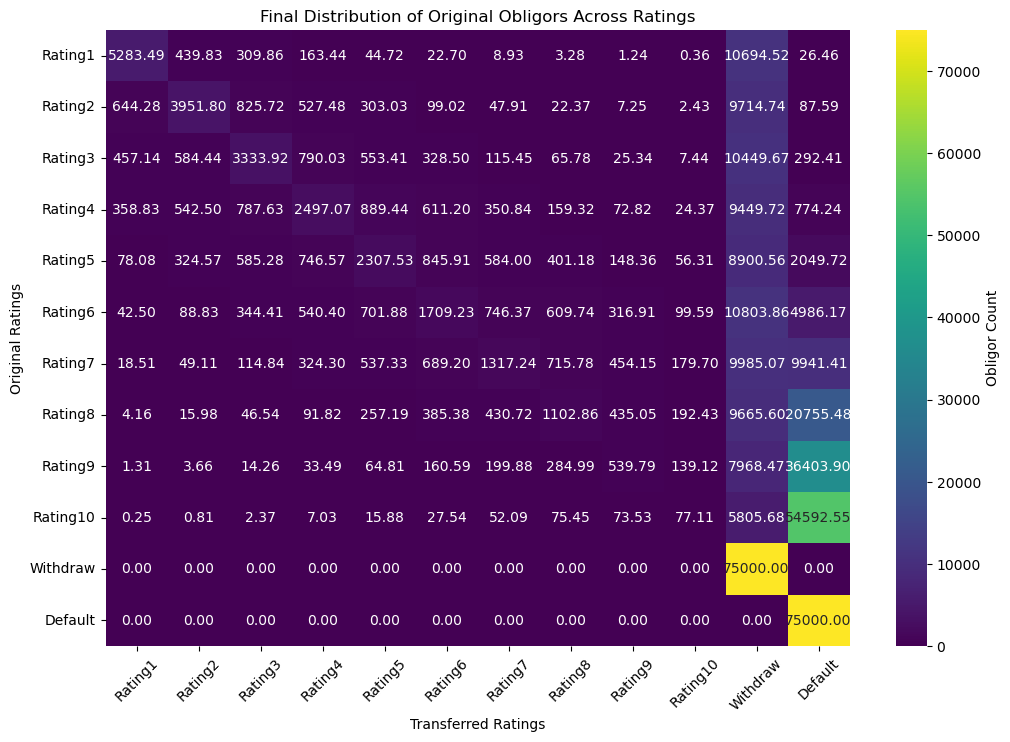

In [64]:
from scipy.stats import multinomial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def simulate_transitions(n_obligors, transition_matrix, quarters=13):
    n_ratings = transition_matrix.shape[0]  # Number of ratings
    n_columns = transition_matrix.shape[1]  # Number of states including Withdraw and Default
    
    cumulative_withdraws = np.zeros((quarters, n_ratings))
    cumulative_defaults = np.zeros((quarters, n_ratings))
    cumulative_survivors = np.zeros((quarters, n_ratings))

    # Initialize obligors matrix with shape (quarters, n_ratings, n_columns)
    obligors = np.zeros((quarters, n_ratings, n_columns))
    for i in range(n_ratings):
        original_obligors_count = n_obligors / n_ratings  # Distribute obligors equally at the start
        obligors[0, i, i] = original_obligors_count
        cumulative_survivors[0, i] = original_obligors_count

    # Function to simulate transitions for a given set of distributions
    def simulate_transitions(distributions, transition_matrix):
        new_distributions = {i: np.zeros(n_columns) for i in range(n_ratings)}
        for rating, dist in distributions.items():
            if np.sum(dist) > 0:
                new_distribution = np.matmul(dist, transition_matrix)
                new_distributions[rating] = new_distribution
        return new_distributions

    for t in range(1, quarters):
        rating_distributions = {i: obligors[t-1, i, :] for i in range(n_ratings)}
        new_distributions = simulate_transitions(rating_distributions, transition_matrix)
        
        for i in range(n_ratings):
            obligors[t, i, :] = new_distributions[i]
            cumulative_withdraws[t, i] = cumulative_withdraws[t-1, i] + obligors[t, i, -2]
            cumulative_defaults[t, i] = cumulative_defaults[t-1, i] + obligors[t, i, -1]
            cumulative_survivors[t, i] = n_obligors / n_ratings - cumulative_withdraws[t, i] - cumulative_defaults[t, i]

    # Calculate marginal default rate for each year
    marginal_default_rates = np.zeros((quarters, n_ratings))
    for t in range(1, quarters):
        for i in range(n_ratings):
            if cumulative_survivors[t-1, i] > 0:
                marginal_default_rates[t, i] = cumulative_defaults[t, i] / cumulative_survivors[t-1, i]
            else:
                marginal_default_rates[t, i] = 0

    # Final matrix for the count of each original obligor
    final_matrix = np.zeros((n_ratings, n_columns))
    final_matrix[:, :-2] = obligors[-1, :, :-2]
    final_matrix[:, -2] = cumulative_withdraws[-1, :]
    final_matrix[:, -1] = cumulative_defaults[-1, :]

    return cumulative_withdraws, cumulative_defaults, cumulative_survivors, obligors, marginal_default_rates, final_matrix

# Each original rating should have 10,000 obligors
n_obligors = 10000 * 10  # 10,000 obligors for each of the 10 original ratings
quarters = 10  # Number of quarters for the simulation

cumulative_withdraws, cumulative_defaults, cumulative_survivors, obligors, marginal_default_rates, final_matrix = simulate_transitions(n_obligors, updated_transition_matrix, quarters)

# Define the row and column labels manually
row_labels = [f'Rating{i+1}' for i in range(10)] + ['Withdraw', 'Default']
column_labels = [f'Rating{i+1}' for i in range(10)] + ['Withdraw', 'Default']

# Display the final matrix
print(pd.DataFrame(final_matrix, index=row_labels, columns=column_labels))

# Visualization code
def visualize_matrix(matrix, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Obligor Count'})
    plt.title(title)
    plt.xlabel('Transferred Ratings')
    plt.ylabel('Original Ratings')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Convert `final_matrix` to a DataFrame for better visualization
final_matrix_df = pd.DataFrame(final_matrix, index=row_labels, columns=column_labels)

# Plot the heatmap
visualize_matrix(final_matrix_df, 'Final Distribution of Original Obligors Across Ratings')